# Wind Tunnel Data

An airframe was mounted in the University of Bristol's 7'x5' wind tunnel. An
[ATI mini45](https://www.ati-ia.com/products/ft/ft_models.aspx?id=mini45) load cell was mounted within the airframe.
This was attached to the pitch traverse of the existing load cell.

Automated control inputs were generated by a set of Python scripts which also automatically recorded load cell data.
The raw wind tunnel data is available in [`wind_tunnel_data/raw`](./wind_tunnel_data/raw). Some notes on
this data can also be found in the folder.

Some pre-processed data can be found in the [`wind_tunnel_data/processed`](./wind_tunnel_data/processed)
folder. This has had the surface angles and lift and drag values calculated. They are saved as Python pickle files.
The pickle files are named with the convention `data_{day}_{airspeed}.pkl`. They have been processed using the
processing scripts in [`processing_scripts`](./processing_scripts).

> NB: The paths in the processing scripts will likely need correcting.

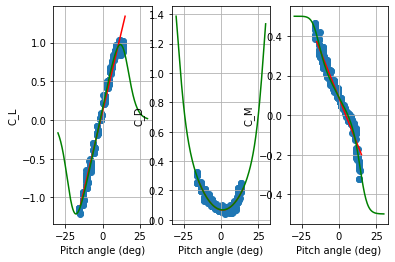

In [9]:
import os
import pickle
import pandas as pd

import processing_scripts.surface_effects as se

sources = [
    ("data_17_10.pkl",10),
    ("data_17_12.5.pkl",12.5),
    ("data_17_15.pkl",15),
    ("data_17_17.5.pkl",17.5),
    ("data_17_20.pkl",20),
    ("data_17_22.5.pkl",22.5),
    ("data_18_10.pkl",10),
    ("data_18_15.pkl",15),
    ("data_18_20.pkl",20)
    ]

data = None

for filename,airspeed in sources:
    newdata = pickle.load(open("wind_tunnel_data/processed/"+filename,"rb"))
    se.add_airspeed_column(newdata,airspeed)
    data = pd.concat([data,newdata])

neutral_data = se.utils.select_neutral(data)

c_lifts,C_lift,C_lift_complex = se.calculate_C_lift(neutral_data)
c_ds,C_drag,C_drag_complex = se.calculate_C_drag(neutral_data)
c_ms,C_M,C_M_complex = se.calculate_C_M(neutral_data)

se.make_top3_plots(neutral_data,
    c_lifts,C_lift,C_lift_complex,
    c_ds,C_drag,C_drag_complex,
    c_ms,C_M,C_M_complex
    )

se.plt.show()
print(f"C_lift parameters: {C_lift_complex}")
print(f"C_drag parameters: {C_drag_complex}")
print(f"C_M parameters: {C_M_complex}")

# Initial Fits

There are a number of functions that have been used to construct the fits, the most basic is the Heaviside
approximation, denoted $H$:

$$
H(x,p,k) = \frac{1}{1 + e^{-2k(x-p)}}
$$

This is approximately $0$ for all $x << p$, and approximately $1$ for all $x >> p$. Around $p$, there is a smooth
transition between the values. As $k \rightarrow \infty$, the function approaches the true Heaviside function about $p$.
If not otherwise specified $k = 10$.

The "heavicentre" function $S$ is approximately $1$ within some range and rolls off to $0$ at the edges. It is defined
as:

$$
S(x,l,h,k) = H(x,l,k) (1-H(x,h,k))
$$

As with the Heaviside approximation, if not otherwise specified, $k = 10$

The $C_L$ fit is defined as:

$$
C_L(\alpha) = S(\alpha,\alpha_{nstall},\alpha_{pstall}) (C_{L0} + C_{L_{\alpha}} \alpha)
$$

This is a linear fit in the centre of the range with a asymptote at $0$ beyond the positive and negative stall angles.
Parameters to fit are: $C_{L0}$, $C_{L_{\alpha}}$, $\alpha_{pstall}$ and $\alpha_{nstall}$

The $C_D$ fit is defined as:

$$
C_D(\alpha) = S(\alpha,-\alpha_{lim},\alpha_{lim}) (C_{D_{\alpha}} (\alpha - \alpha_{C_{D0}})^2 + C_{D0} )
            + 2 (1-S(\alpha,-\alpha_{lim},\alpha_{lim}))
$$

This is a quadratic fit in the centre of the range with a asymptote at $2$ beyond $\alpha_{lim}$.
Parameters to fit are: $C_{D0}$, $C_{D_{\alpha}}$ and $\alpha_{C_{D0}}$.

The $C_M$ fit is defined as:

$$
C_M(\alpha) = S(\alpha,-\alpha_{lim},\alpha_{lim},12) (v \tan(h(\alpha-\alpha_{C_{M0}})) + C_{M0})
        +  0.5 (1.0-H(\alpha,-\alpha_{lim},12))
        -0.5 H(\alpha,\alpha_{lim},12)
$$

This is a $\tan$-based fit in the centre of the range, with asymptotes to $0.5$ and $-0.5$ on the negative and positive
ranges respectively. Note that for $S(\cdot)$ and $H(\cdot)$, $k = 12$. Parameters to fit are: $C_{M0}$,
$\alpha_{C_{M0}}$, $h$ and $v$. $\alpha_{lim} = 15\degree$

All parameter values are fitted for $\alpha$ and all other angles in radians.
